# Introduction

New York City's demographics shows that is is large and ethnically divers metropolis.
With its divers nature, comes divers food items. There are many restaurants in New York City , each belonging different category like Indian , French, Chinese, German etc etc.
So as part of this project, we will list and visualize all major parts of New York City that has great indian restaurants.¶

## Data

Data For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. Data source : https://cocl.us/new_york_dataset Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city. Indian resturants in each neighborhood of new york city. Data source : Fousquare API Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants. GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

## Approach

- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Indian Resturants.
- Find rating , tips and like count for each Indian Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

## Analysis Questions

- What is best location in New York City for Indian Cuisine ?
- Which areas have potential Indian Resturant Market ?
- Which all areas lack Indian Resturants ?
- Which is the best place to stay if I prefer Indian Cuisine ?

## Required Libraries

- Pandas and numpy for data handing
- Module for Foursquare API
- follium to visualize map

In [15]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests as req
import sys
from bs4 import BeautifulSoup
import folium
# import geocoder
import os
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print("Libraries Imported")

Libraries Imported


In [8]:
# Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [57]:
#We define a function to intract with FourSquare API and get top 100 venues within a radius of 
#1000 metres for a given latitude and longitude. Below function will return us the venue id , 
#venue name and category.
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'AHTIA5OYCGRVLLBQPPDYDFCZVLUOBCXKSH0OBJK0QUSAJXMK' 
    CLIENT_SECRET = 'Z1O300YSKIKBBIPIZ0A21GLKGMNYX1XVAH4EZ3JTNDXCPOPQ' 
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = req.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [58]:
# Defining the Venue details like venue Id, count, tips etc etc
def get_venue_details(venue_id):
    
    CLIENT_ID = 'AHTIA5OYCGRVLLBQPPDYDFCZVLUOBCXKSH0OBJK0QUSAJXMK' 
    CLIENT_SECRET = 'Z1O300YSKIKBBIPIZ0A21GLKGMNYX1XVAH4EZ3JTNDXCPOPQ'    
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = req.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [55]:
# Defining New York City Data
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=req.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [17]:
# Get new York Data
new_york_data = get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [18]:
new_york_data.shape

(306, 4)

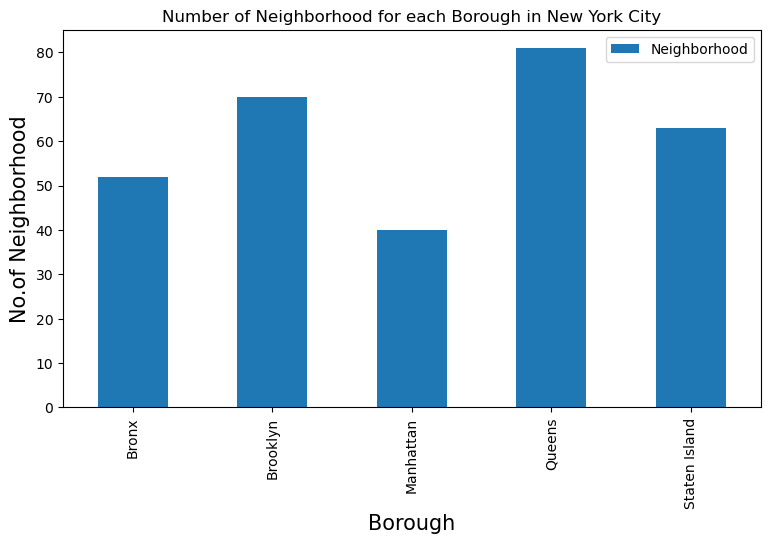

In [19]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Queens has mor enumber of neighnouthood

Now lets collect indian restaurants for eah neighbourhood

In [23]:
# Neighbouthood data with indian restaurants

column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
done
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
done
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
done
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Indian Resturants in Ford

done
( 132 / 306 ) Indian Resturants in Jackson Heights, Queens:5
done
( 133 / 306 ) Indian Resturants in Elmhurst, Queens:3
done
( 134 / 306 ) Indian Resturants in Howard Beach, Queens:0
done
( 135 / 306 ) Indian Resturants in Corona, Queens:0
done
( 136 / 306 ) Indian Resturants in Forest Hills, Queens:0
done
( 137 / 306 ) Indian Resturants in Kew Gardens, Queens:2
done
( 138 / 306 ) Indian Resturants in Richmond Hill, Queens:8
done
( 139 / 306 ) Indian Resturants in Flushing, Queens:0
done
( 140 / 306 ) Indian Resturants in Long Island City, Queens:2
done
( 141 / 306 ) Indian Resturants in Sunnyside, Queens:1
done
( 142 / 306 ) Indian Resturants in East Elmhurst, Queens:0
done
( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
done
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
done
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
done
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
done
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
done
( 148 / 306 ) 

done
( 259 / 306 ) Indian Resturants in Elm Park, Staten Island:0
done
( 260 / 306 ) Indian Resturants in Remsen Village, Brooklyn:0
done
( 261 / 306 ) Indian Resturants in New Lots, Brooklyn:0
done
( 262 / 306 ) Indian Resturants in Paerdegat Basin, Brooklyn:0
done
( 263 / 306 ) Indian Resturants in Mill Basin, Brooklyn:0
done
( 264 / 306 ) Indian Resturants in Jamaica Hills, Queens:4
done
( 265 / 306 ) Indian Resturants in Utopia, Queens:0
done
( 266 / 306 ) Indian Resturants in Pomonok, Queens:0
done
( 267 / 306 ) Indian Resturants in Astoria Heights, Queens:1
done
( 268 / 306 ) Indian Resturants in Claremont Village, Bronx:0
done
( 269 / 306 ) Indian Resturants in Concourse Village, Bronx:1
done
( 270 / 306 ) Indian Resturants in Mount Eden, Bronx:0
done
( 271 / 306 ) Indian Resturants in Mount Hope, Bronx:0
done
( 272 / 306 ) Indian Resturants in Sutton Place, Manhattan:3
done
( 273 / 306 ) Indian Resturants in Hunters Point, Queens:0
done
( 274 / 306 ) Indian Resturants in Turtle

In [24]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [25]:
indian_rest_ny.shape

(144, 4)

We got 144 Indian restaurants in new york city

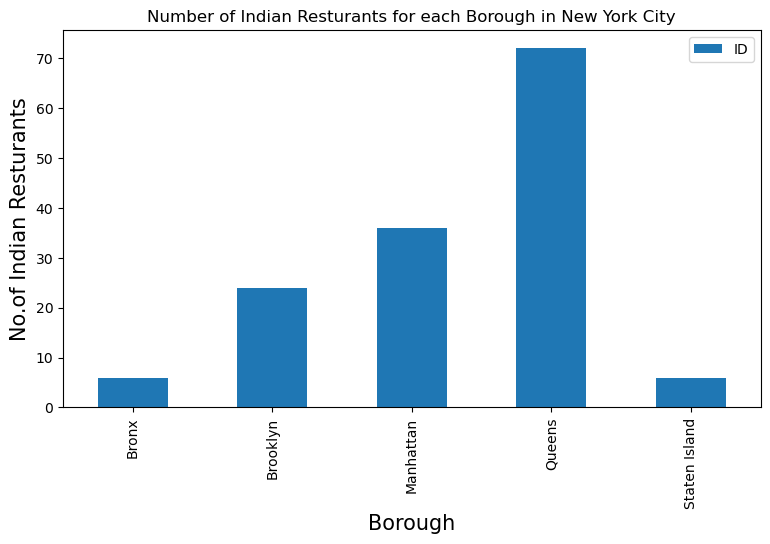

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We See that Queens has the most number of indian restaurants

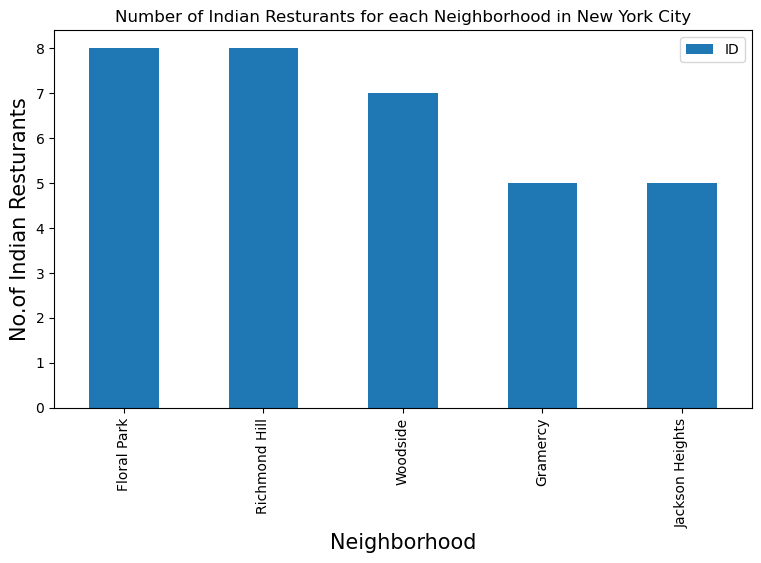

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [29]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
102,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
103,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
104,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
105,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
106,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
107,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
108,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
109,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


We see that Floral Park in Queens has the most number of indian restaurants with total count of 8



In [59]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

https://api.foursquare.com/v2/venues/4c0448d9310fc9b6bf1dc761?&client_id=AHTIA5OYCGRVLLBQPPDYDFCZVLUOBCXKSH0OBJK0QUSAJXMK&client_secret=Z1O300YSKIKBBIPIZ0A21GLKGMNYX1XVAH4EZ3JTNDXCPOPQ&v=20180605
{'meta': {'code': 200, 'requestId': '5fc5f3319e7d3348a3dd929b'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d489

{'meta': {'code': 200, 'requestId': '5fc5f332d6f4d92e6542a136'}, 'response': {'venue': {'id': '4c194631838020a13e78e561', 'name': 'Melanies Roti Bar And Grill', 'contact': {'phone': '7184091088', 'formattedPhone': '(718) 409-1088'}, 'location': {'address': '1248 Castle Hill Ave', 'crossStreet': 'Newbold Ave', 'lat': 40.833293, 'lng': -73.85104, 'labeledLatLngs': [{'label': 'display', 'lat': 40.833293, 'lng': -73.85104}, {'label': 'entrance', 'lat': 40.833276, 'lng': -73.851166}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1248 Castle Hill Ave (Newbold Ave)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/melanies-roti-bar-and-grill/4c194631838020a13e78e561', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.pn

{'meta': {'code': 200, 'requestId': '5fc5f332ea7b29205e8936d0'}, 'response': {'venue': {'id': '4c04544df423a593ac83d116', 'name': 'Cumin Indian Cuisine', 'contact': {}, 'location': {'address': '3549 Johnson Ave', 'lat': 40.886458613786466, 'lng': -73.90981597247142, 'labeledLatLngs': [{'label': 'display', 'lat': 40.886458613786466, 'lng': -73.90981597247142}, {'label': 'entrance', 'lat': 40.886478, 'lng': -73.90987}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3549 Johnson Ave', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cumin-indian-cuisine/4c04544df423a593ac83d116', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'price': {'tier': 2

{'meta': {'code': 200, 'requestId': '5fc5f333ea7b29205e8938c6'}, 'response': {'venue': {'id': '551b7f75498e86c00a0ed2e1', 'name': 'Hungry Bird', 'contact': {'phone': '9178014900', 'formattedPhone': '(917) 801-4900'}, 'location': {'address': '980 Morris Ave', 'crossStreet': '164th and 165th Streets', 'lat': 40.82881986636983, 'lng': -73.91682784225715, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82881986636983, 'lng': -73.91682784225715}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['980 Morris Ave (164th and 165th Streets)', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hungry-bird/551b7f75498e86c00a0ed2e1', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '5fc5f334432e02660c9ab284'}, 'response': {'venue': {'id': '4b5a4dc8f964a520a2bb28e3', 'name': 'Taj Mahal', 'contact': {'phone': '7188361512', 'formattedPhone': '(718) 836-1512'}, 'location': {'address': '7315 3rd Ave', 'lat': 40.632373, 'lng': -74.027193, 'labeledLatLngs': [{'label': 'display', 'lat': 40.632373, 'lng': -74.027193}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7315 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taj-mahal/4b5a4dc8f964a520a2bb28e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 26}, 'url': 'http://tajmahalbrooklyn.com', 'price': {'tier': 2, 'message': 'Moderat

{'meta': {'code': 200, 'requestId': '5fc5f335ac80632fabadc37d'}, 'response': {'venue': {'id': '545835a1498e820edc6f636f', 'name': 'Bombay Grill', 'contact': {'phone': '7184912500', 'formattedPhone': '(718) 491-2500'}, 'location': {'address': '8716 3rd Ave', 'lat': 40.622371, 'lng': -74.03179899999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622371, 'lng': -74.03179899999999}, {'label': 'entrance', 'lat': 40.622344, 'lng': -74.031673}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8716 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-grill/545835a1498e820edc6f636f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4

{'meta': {'code': 200, 'requestId': '5fc5f3363689252594cbccfc'}, 'response': {'venue': {'id': '52213c4211d295d4c57a607c', 'name': 'Ashoka Grill', 'contact': {'phone': '7184341001', 'formattedPhone': '(718) 434-1001'}, 'location': {'address': '1436 Flatbush Ave', 'crossStreet': 'Farragut Avenue', 'lat': 40.635821694890055, 'lng': -73.95081967691863, 'labeledLatLngs': [{'label': 'display', 'lat': 40.635821694890055, 'lng': -73.95081967691863}, {'label': 'entrance', 'lat': 40.635644, 'lng': -73.950869}], 'postalCode': '11210', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1436 Flatbush Ave (Farragut Avenue)', 'Brooklyn, NY 11210', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ashoka-grill/52213c4211d295d4c57a607c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 

{'meta': {'code': 200, 'requestId': '5fc5f33811398a33e7efd569'}, 'response': {'venue': {'id': '512a9ea9e4b004fb8eeb84e5', 'name': 'Silver Krust', 'contact': {'phone': '7186290010', 'formattedPhone': '(718) 629-0010'}, 'location': {'address': '5253 Avenue D', 'crossStreet': 'E.53rd st', 'lat': 40.64249, 'lng': -73.926862, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64249, 'lng': -73.926862}, {'label': 'entrance', 'lat': 40.64241, 'lng': -73.926689}], 'postalCode': '11203', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5253 Avenue D (E.53rd st)', 'Brooklyn, NY 11203', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/silver-krust/512a9ea9e4b004fb8eeb84e5', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '5fc5f33949df1e26436a403b'}, 'response': {'venue': {'id': '4b718914f964a520c04b2de3', 'name': 'Madina Restaurant and Sweets', 'contact': {'phone': '7184693535', 'formattedPhone': '(718) 469-3535'}, 'location': {'address': '563 Coney Island Ave', 'crossStreet': 'Beverly Rd & Lewis Pl', 'lat': 40.64369687020608, 'lng': -73.96999901276827, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64369687020608, 'lng': -73.96999901276827}, {'label': 'entrance', 'lat': 40.643601, 'lng': -73.969868}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['563 Coney Island Ave (Beverly Rd & Lewis Pl)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/madina-restaurant-and-sweets/4b718914f964a520c04b2de3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https:

{'meta': {'code': 200, 'requestId': '5fc5f339d6f4d92e6542b760'}, 'response': {'venue': {'id': '52f18573498ec2c34e830ffd', 'name': "Kanan's Indian Restaurant", 'contact': {'phone': '7183693777', 'formattedPhone': '(718) 369-3777'}, 'location': {'address': '452 3rd Ave', 'crossStreet': '9th Street', 'lat': 40.671890999999995, 'lng': -73.99094000000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.671890999999995, 'lng': -73.99094000000001}, {'label': 'entrance', 'lat': 40.671842, 'lng': -73.990867}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['452 3rd Ave (9th Street)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kanans-indian-restaurant/52f18573498ec2c34e830ffd', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_

{'meta': {'code': 200, 'requestId': '5fc5f33a96ddb32136ccf6b5'}, 'response': {'venue': {'id': '57596dad498e732300496b23', 'name': 'Dosa Royale', 'contact': {'phone': '7185763800', 'formattedPhone': '(718) 576-3800'}, 'location': {'address': '258 Dekalb Ave', 'lat': 40.689466368706604, 'lng': -73.96870434089776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689466368706604, 'lng': -73.96870434089776}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['258 Dekalb Ave', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dosa-royale/57596dad498e732300496b23', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 24}, 'url': 'http://www.dosaroyale.com', 

{'meta': {'code': 200, 'requestId': '5fc5f33b92d28855b9843f45'}, 'response': {'venue': {'id': '57596dad498e732300496b23', 'name': 'Dosa Royale', 'contact': {'phone': '7185763800', 'formattedPhone': '(718) 576-3800'}, 'location': {'address': '258 Dekalb Ave', 'lat': 40.689466368706604, 'lng': -73.96870434089776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689466368706604, 'lng': -73.96870434089776}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['258 Dekalb Ave', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dosa-royale/57596dad498e732300496b23', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 24}, 'url': 'http://www.dosaroyale.com', 

{'meta': {'code': 200, 'requestId': '5fc5f33bed02d54fbf6e693d'}, 'response': {'venue': {'id': '568d3902498e619efcbc3f58', 'name': 'Spice & Grill', 'contact': {}, 'location': {'address': '441 Myrtle Ave', 'crossStreet': 'Waverly', 'lat': 40.693389, 'lng': -73.968028, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693389, 'lng': -73.968028}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['441 Myrtle Ave (Waverly)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/spice--grill/568d3902498e619efcbc3f58', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 21, 'gro

{'meta': {'code': 200, 'requestId': '5fc5f33c08692b75e634752c'}, 'response': {'venue': {'id': '5539753f498edbace4746b67', 'name': 'Tandoori Masala', 'contact': {'phone': '3473782396', 'formattedPhone': '(347) 378-2396'}, 'location': {'address': '1695 Broadway', 'lat': 40.683978, 'lng': -73.911891, 'labeledLatLngs': [{'label': 'display', 'lat': 40.683978, 'lng': -73.911891}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1695 Broadway', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tandoori-masala/5539753f498edbace4746b67', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'li

{'meta': {'code': 200, 'requestId': '5fc5f33e0e79470f4ecdf2f1'}, 'response': {'venue': {'id': '519ff6c8498e1300ddcbd45c', 'name': 'Anarkali Indian Cuisine', 'contact': {'phone': '7182822200', 'formattedPhone': '(718) 282-2200'}, 'location': {'address': '1125 Church Ave', 'lat': 40.647488, 'lng': -73.96860500000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.647488, 'lng': -73.96860500000001}, {'label': 'entrance', 'lat': 40.647374, 'lng': -73.968584}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1125 Church Ave', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/anarkali-indian-cuisine/519ff6c8498e1300ddcbd45c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fa

{'meta': {'code': 200, 'requestId': '5fc5f33eea7b29205e89585c'}, 'response': {'venue': {'id': '4db0f4371e729fcc56497f20', 'name': 'Mashallah', 'contact': {'phone': '7182870090', 'formattedPhone': '(718) 287-0090'}, 'location': {'address': '663 Coney Island Ave', 'crossStreet': 'btwn Slocum Pl & Cortelyou Rd', 'lat': 40.641231427270235, 'lng': -73.9693211845751, 'labeledLatLngs': [{'label': 'display', 'lat': 40.641231427270235, 'lng': -73.9693211845751}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['663 Coney Island Ave (btwn Slocum Pl & Cortelyou Rd)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mashallah/4db0f4371e729fcc56497f20', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True

{'meta': {'code': 200, 'requestId': '5fc5f34072ff466320f1acab'}, 'response': {'venue': {'id': '5631511b498e3d6d7e0a4df0', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7187682262', 'formattedPhone': '(718) 768-2262'}, 'location': {'address': '185 Grand Street', 'lat': 40.71434305888687, 'lng': -73.96090327883888, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71434305888687, 'lng': -73.96090327883888}, {'label': 'entrance', 'lat': 40.714397, 'lng': -73.960787}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['185 Grand Street', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5631511b498e3d6d7e0a4df0', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '5fc5f340f55f360d58db1088'}, 'response': {'venue': {'id': '545835a1498e820edc6f636f', 'name': 'Bombay Grill', 'contact': {'phone': '7184912500', 'formattedPhone': '(718) 491-2500'}, 'location': {'address': '8716 3rd Ave', 'lat': 40.622371, 'lng': -74.03179899999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622371, 'lng': -74.03179899999999}, {'label': 'entrance', 'lat': 40.622344, 'lng': -74.031673}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8716 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-grill/545835a1498e820edc6f636f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4

{'meta': {'code': 200, 'requestId': '5fc5f342432e02660c9ad824'}, 'response': {'venue': {'id': '54c2bd96498eaf5142e3fe92', 'name': 'Clove Indian Restaurant & Bar', 'contact': {'phone': '6469186644', 'formattedPhone': '(646) 918-6644', 'twitter': 'cloveindian'}, 'location': {'address': '1592 Amsterdam Ave', 'crossStreet': 'btwn 139th St & 138th St', 'lat': 40.82128, 'lng': -73.95062, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82128, 'lng': -73.95062}, {'label': 'entrance', 'lat': 40.821289, 'lng': -73.950696}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1592 Amsterdam Ave (btwn 139th St & 138th St)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/clove-indian-restaurant--bar/54c2bd96498eaf5142e3fe92', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '5fc5f342b144236e126f9507'}, 'response': {'venue': {'id': '5914ff32b23dfa207eca38de', 'name': 'Mumbai Masala', 'contact': {'phone': '2123680100', 'formattedPhone': '(212) 368-0100'}, 'location': {'address': '1768 Amsterdam Ave', 'lat': 40.826928, 'lng': -73.946713, 'labeledLatLngs': [{'label': 'display', 'lat': 40.826928, 'lng': -73.946713}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1768 Amsterdam Ave', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mumbai-masala/5914ff32b23dfa207eca38de', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'

{'meta': {'code': 200, 'requestId': '5fc5f3431edf443c9ef0dc6d'}, 'response': {'venue': {'id': '54c2bd96498eaf5142e3fe92', 'name': 'Clove Indian Restaurant & Bar', 'contact': {'phone': '6469186644', 'formattedPhone': '(646) 918-6644', 'twitter': 'cloveindian'}, 'location': {'address': '1592 Amsterdam Ave', 'crossStreet': 'btwn 139th St & 138th St', 'lat': 40.82128, 'lng': -73.95062, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82128, 'lng': -73.95062}, {'label': 'entrance', 'lat': 40.821289, 'lng': -73.950696}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1592 Amsterdam Ave (btwn 139th St & 138th St)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/clove-indian-restaurant--bar/54c2bd96498eaf5142e3fe92', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '5fc5f34401f51442cae24c1e'}, 'response': {'venue': {'id': '56d87f3d498ee215abee5724', 'name': 'Delhi Masala', 'contact': {'phone': '2126668600', 'formattedPhone': '(212) 666-8600'}, 'location': {'address': '2077 Adam Clayton Powell Jr Blvd', 'crossStreet': '124th Street', 'lat': 40.808009000000006, 'lng': -73.948587, 'labeledLatLngs': [{'label': 'display', 'lat': 40.808009000000006, 'lng': -73.948587}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2077 Adam Clayton Powell Jr Blvd (124th Street)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/delhi-masala/56d87f3d498ee215abee5724', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fa

{'meta': {'code': 200, 'requestId': '5fc5f34514924349705d287f'}, 'response': {'venue': {'id': '54c2bd96498eaf5142e3fe92', 'name': 'Clove Indian Restaurant & Bar', 'contact': {'phone': '6469186644', 'formattedPhone': '(646) 918-6644', 'twitter': 'cloveindian'}, 'location': {'address': '1592 Amsterdam Ave', 'crossStreet': 'btwn 139th St & 138th St', 'lat': 40.82128, 'lng': -73.95062, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82128, 'lng': -73.95062}, {'label': 'entrance', 'lat': 40.821289, 'lng': -73.950696}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1592 Amsterdam Ave (btwn 139th St & 138th St)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/clove-indian-restaurant--bar/54c2bd96498eaf5142e3fe92', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '5fc5f345ac80632fabadf046'}, 'response': {'venue': {'id': '519fe6f5498e30595d370c44', 'name': 'Bawarchi', 'contact': {'phone': '2122897718', 'formattedPhone': '(212) 289-7718'}, 'location': {'address': '1546 Madison Ave', 'crossStreet': 'Between 104 and 105th', 'lat': 40.792797, 'lng': -73.950383, 'labeledLatLngs': [{'label': 'display', 'lat': 40.792797, 'lng': -73.950383}, {'label': 'entrance', 'lat': 40.79276, 'lng': -73.950291}], 'postalCode': '10029', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1546 Madison Ave (Between 104 and 105th)', 'New York, NY 10029', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bawarchi/519fe6f5498e30595d370c44', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': Tru

{'meta': {'code': 200, 'requestId': '5fc5f346a4d7af1eca7e6062'}, 'response': {'venue': {'id': '56ed855a498ef3bb022352c3', 'name': 'Mughlai Indian Cuisine', 'contact': {'phone': '2127226262', 'formattedPhone': '(212) 722-6262'}, 'location': {'address': '1724 2nd Ave', 'crossStreet': '89th & 90th St', 'lat': 40.78020580283837, 'lng': -73.95008785684102, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78020580283837, 'lng': -73.95008785684102}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1724 2nd Ave (89th & 90th St)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mughlai-indian-cuisine/56ed855a498ef3bb022352c3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5fc5f3470e79470f4ece0d4f'}, 'response': {'venue': {'id': '5b0c8e2d2f97ec002c67a428', 'name': 'Ashoka Fine Dine', 'contact': {}, 'location': {'lat': 40.779918, 'lng': -73.950142, 'labeledLatLngs': [{'label': 'display', 'lat': 40.779918, 'lng': -73.950142}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ashoka-fine-dine/5b0c8e2d2f97ec002c67a428', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count': 10, 'items': []}], 'summary': '10 Likes'}

{'meta': {'code': 200, 'requestId': '5fc5f348da740e58ce0ad497'}, 'response': {'venue': {'id': '591890f43abcaf1ddca66e85', 'name': 'Ashoka', 'contact': {}, 'location': {'address': '489 Columbus Ave', 'lat': 40.784842463371454, 'lng': -73.97325299421942, 'labeledLatLngs': [{'label': 'display', 'lat': 40.784842463371454, 'lng': -73.97325299421942}, {'label': 'entrance', 'lat': 40.784824, 'lng': -73.973178}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['489 Columbus Ave', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ashoka/591890f43abcaf1ddca66e85', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'url': 'http://ashokanyc.com', 'price': 

{'meta': {'code': 200, 'requestId': '5fc5f349f99ae9677b8f2c50'}, 'response': {'venue': {'id': '42489a80f964a5208b201fe3', 'name': 'Swagat', 'contact': {'phone': '2123621400', 'formattedPhone': '(212) 362-1400', 'twitter': 'swagatny'}, 'location': {'address': '411 Amsterdam Ave', 'crossStreet': 'btwn 80th St & 79th St', 'lat': 40.783573082941615, 'lng': -73.97803042905113, 'labeledLatLngs': [{'label': 'display', 'lat': 40.783573082941615, 'lng': -73.97803042905113}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['411 Amsterdam Ave (btwn 80th St & 79th St)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/swagat/42489a80f964a5208b201fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '5fc5f349b4e1ed177c80ed86'}, 'response': {'venue': {'id': '4b4aab62f964a520978c26e3', 'name': 'Dil-e Punjab Deli', 'contact': {'phone': '2126479428', 'formattedPhone': '(212) 647-9428', 'twitter': 'dilepunjabdeli'}, 'location': {'address': '170 9th Ave', 'crossStreet': 'at 21st St', 'lat': 40.74484451009235, 'lng': -74.00252750283143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74484451009235, 'lng': -74.00252750283143}, {'label': 'entrance', 'lat': 40.744917, 'lng': -74.002266}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 9th Ave (at 21st St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dile-punjab-deli/4b4aab62f964a520978c26e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '5fc5f34a46cb367b6ee8a869'}, 'response': {'venue': {'id': '5b5a2c9e66f3cd002ca0aab5', 'name': 'Bombay Bistros', 'contact': {'phone': '6468503719', 'formattedPhone': '(646) 850-3719', 'twitter': 'drunkenmunkeys', 'facebook': '2203117713062975', 'facebookUsername': '31corneliast', 'facebookName': 'The Drunken Munkey'}, 'location': {'address': '31 Cornelia St', 'crossStreet': 'between Bleecker St. and W. 4th St.', 'lat': 40.73136, 'lng': -74.00253, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73136, 'lng': -74.00253}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['31 Cornelia St (between Bleecker St. and W. 4th St.)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-bistros/5b5a2c9e66f3cd002ca0aab5', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian',

{'meta': {'code': 200, 'requestId': '5fc5f34a5f561c659f24f96e'}, 'response': {'venue': {'id': '4bbb9dbded7776b0e1ad3e51', 'name': 'Tamarind TriBeCa', 'contact': {'phone': '2127759000', 'formattedPhone': '(212) 775-9000', 'facebook': '201503306550753', 'facebookName': 'Tamarind Tribeca'}, 'location': {'address': '99 Hudson St', 'crossStreet': 'at Franklin St', 'lat': 40.71921117375622, 'lng': -74.00872657957527, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71921117375622, 'lng': -74.00872657957527}, {'label': 'entrance', 'lat': 40.719084, 'lng': -74.008899}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['99 Hudson St (at Franklin St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tamarind-tribeca/4bbb9dbded7776b0e1ad3e51', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '5fc5f34b46cb367b6ee8abaa'}, 'response': {'venue': {'id': '5b5a2c9e66f3cd002ca0aab5', 'name': 'Bombay Bistros', 'contact': {'phone': '6468503719', 'formattedPhone': '(646) 850-3719', 'twitter': 'drunkenmunkeys', 'facebook': '2203117713062975', 'facebookUsername': '31corneliast', 'facebookName': 'The Drunken Munkey'}, 'location': {'address': '31 Cornelia St', 'crossStreet': 'between Bleecker St. and W. 4th St.', 'lat': 40.73136, 'lng': -74.00253, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73136, 'lng': -74.00253}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['31 Cornelia St (between Bleecker St. and W. 4th St.)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-bistros/5b5a2c9e66f3cd002ca0aab5', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian',

{'meta': {'code': 200, 'requestId': '5fc5f34c49df1e26436a74fa'}, 'response': {'venue': {'id': '591794df2be42556988e4a8e', 'name': 'Rahi', 'contact': {'phone': '2123738900', 'formattedPhone': '(212) 373-8900', 'instagram': 'rahinyc', 'facebook': '1285983764842594', 'facebookUsername': 'rahinyc', 'facebookName': 'Rahi'}, 'location': {'address': '60 Greenwich Ave', 'crossStreet': 'Perry St and Greenwich Ave', 'lat': 40.73596784486649, 'lng': -74.00078323150706, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73596784486649, 'lng': -74.00078323150706}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Greenwich Ave (Perry St and Greenwich Ave)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rahi/591794df2be42556988e4a8e', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'h

{'meta': {'code': 200, 'requestId': '5fc5f34c0525d445197e3e80'}, 'response': {'venue': {'id': '538ba1f2498e279098e4210a', 'name': 'Awadh', 'contact': {'phone': '6468613604', 'formattedPhone': '(646) 861-3604', 'twitter': 'awadhnyc'}, 'location': {'address': '2588 Broadway', 'crossStreet': '98 Street', 'lat': 40.79572232174015, 'lng': -73.97103124622318, 'labeledLatLngs': [{'label': 'display', 'lat': 40.79572232174015, 'lng': -73.97103124622318}, {'label': 'entrance', 'lat': 40.795623, 'lng': -73.970764}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2588 Broadway (98 Street)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/awadh/538ba1f2498e279098e4210a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5fc5f34df295167c83d2f3ab'}, 'response': {'venue': {'id': '49c5ad0af964a5201b571fe3', 'name': 'Roti Roll', 'contact': {'phone': '2126661500', 'formattedPhone': '(212) 666-1500'}, 'location': {'address': '994 Amsterdam Ave', 'crossStreet': '109th St', 'lat': 40.802476908363275, 'lng': -73.96429385747197, 'labeledLatLngs': [{'label': 'display', 'lat': 40.802476908363275, 'lng': -73.96429385747197}, {'label': 'entrance', 'lat': 40.802587, 'lng': -73.964354}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['994 Amsterdam Ave (109th St)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/roti-roll/49c5ad0af964a5201b571fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5fc5f34ddb10fc595b7eead4'}, 'response': {'venue': {'id': '49c5ad0af964a5201b571fe3', 'name': 'Roti Roll', 'contact': {'phone': '2126661500', 'formattedPhone': '(212) 666-1500'}, 'location': {'address': '994 Amsterdam Ave', 'crossStreet': '109th St', 'lat': 40.802476908363275, 'lng': -73.96429385747197, 'labeledLatLngs': [{'label': 'display', 'lat': 40.802476908363275, 'lng': -73.96429385747197}, {'label': 'entrance', 'lat': 40.802587, 'lng': -73.964354}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['994 Amsterdam Ave (109th St)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/roti-roll/49c5ad0af964a5201b571fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, '

{'meta': {'code': 200, 'requestId': '5fc5f34edb10fc595b7eec78'}, 'response': {'venue': {'id': '529d382a11d2dd5ef107e641', 'name': 'Chapati House - NYC', 'contact': {'phone': '2127497200', 'formattedPhone': '(212) 749-7200', 'twitter': 'chapatihousenyc'}, 'location': {'address': '3153 Broadway', 'crossStreet': 'Tiemann Pl.', 'lat': 40.81457249971737, 'lng': -73.95915381671377, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81457249971737, 'lng': -73.95915381671377}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3153 Broadway (Tiemann Pl.)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chapati-house--nyc/529d382a11d2dd5ef107e641', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '5fc5f34f050c132220518086'}, 'response': {'venue': {'id': '4a70a75bf964a52016d81fe3', 'name': 'Bhatti Indian Grill', 'contact': {'phone': '2126834228', 'formattedPhone': '(212) 683-4228'}, 'location': {'address': '100 Lexington Ave', 'crossStreet': 'at E 27th St', 'lat': 40.74206502425499, 'lng': -73.98298343609093, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74206502425499, 'lng': -73.98298343609093}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['100 Lexington Ave (at E 27th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bhatti-indian-grill/4a70a75bf964a52016d81fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True

{'meta': {'code': 200, 'requestId': '5fc5f34fed02d54fbf6ea156'}, 'response': {'venue': {'id': '57f7cbbe498edf8f07c7ba83', 'name': 'Sahib', 'contact': {'phone': '6465900994', 'formattedPhone': '(646) 590-0994'}, 'location': {'address': '104 Lexington Ave', 'crossStreet': 'at 27th St', 'lat': 40.74221158817567, 'lng': -73.98287772503384, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74221158817567, 'lng': -73.98287772503384}, {'label': 'entrance', 'lat': 40.742268, 'lng': -73.982891}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['104 Lexington Ave (at 27th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sahib/57f7cbbe498edf8f07c7ba83', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primar

{'meta': {'code': 200, 'requestId': '5fc5f350a4d7af1eca7e7a8d'}, 'response': {'venue': {'id': '523b2b42498e1dfabcc8ab15', 'name': 'Pippali', 'contact': {'phone': '2126891999', 'formattedPhone': '(212) 689-1999'}, 'location': {'address': '129 E 27th St', 'crossStreet': 'Park Ave South', 'lat': 40.74225953806864, 'lng': -73.98339018531439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74225953806864, 'lng': -73.98339018531439}], 'postalCode': '10016', 'cc': 'US', 'neighborhood': 'Rose Hill', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['129 E 27th St (Park Ave South)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pippali/523b2b42498e1dfabcc8ab15', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fal

{'meta': {'code': 200, 'requestId': '5fc5f351b144236e126fbcf6'}, 'response': {'venue': {'id': '43d537d0f964a520402e1fe3', 'name': 'Vatan', 'contact': {'phone': '2126895666', 'formattedPhone': '(212) 689-5666'}, 'location': {'address': '409 3rd Ave', 'crossStreet': 'at 29th', 'lat': 40.74244047116085, 'lng': -73.98046073418793, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74244047116085, 'lng': -73.98046073418793}, {'label': 'entrance', 'lat': 40.742363, 'lng': -73.980374}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['409 3rd Ave (at 29th)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/vatan/43d537d0f964a520402e1fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '5fc5f351ac80632fabae11d5'}, 'response': {'venue': {'id': '4a12eb1ff964a52099771fe3', 'name': 'Dhaba', 'contact': {'phone': '2126791284', 'formattedPhone': '(212) 679-1284', 'twitter': 'dhabanyc', 'facebook': '603662103041500', 'facebookUsername': 'dhabanyc', 'facebookName': 'Dhaba Indian Cuisine'}, 'location': {'address': '108 Lexington Ave', 'crossStreet': 'btwn 27th & 28th St.', 'lat': 40.74233843496071, 'lng': -73.98274966362429, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74233843496071, 'lng': -73.98274966362429}, {'label': 'entrance', 'lat': 40.74236, 'lng': -73.982826}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['108 Lexington Ave (btwn 27th & 28th St.)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dhaba/4a12eb1ff964a52099771fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 

{'meta': {'code': 200, 'requestId': '5fc5f3529ec77475404f6b7b'}, 'response': {'venue': {'id': '5d8d9c5e0a2ffc0008f28855', 'name': 'The Gully', 'contact': {'phone': '7188873933', 'formattedPhone': '(718) 887-3933'}, 'location': {'address': '2545 Steinway St', 'lat': 40.766719, 'lng': -73.91241, 'labeledLatLngs': [{'label': 'display', 'lat': 40.766719, 'lng': -73.91241}], 'postalCode': '11103', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2545 Steinway St', 'New York, NY 11103', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-gully/5d8d9c5e0a2ffc0008f28855', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'

{'meta': {'code': 200, 'requestId': '5fc5f353ac80632fabae15f6'}, 'response': {'venue': {'id': '4aa56c81f964a5204e4820e3', 'name': 'Seva Indian Cuisine', 'contact': {'phone': '7186264440', 'formattedPhone': '(718) 626-4440'}, 'location': {'address': '30-07 34th St', 'crossStreet': 'btwn 30th & 31st Ave.', 'lat': 40.76552091157529, 'lng': -73.91915721566768, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76552091157529, 'lng': -73.91915721566768}], 'postalCode': '11103', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['30-07 34th St (btwn 30th & 31st Ave.)', 'Astoria, NY 11103', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/seva-indian-cuisine/4aa56c81f964a5204e4820e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '5fc5f353da740e58ce0af475'}, 'response': {'venue': {'id': '4b998d3ff964a520fc8235e3', 'name': 'Maharaja Sweets & Snacks', 'contact': {'phone': '7185052680', 'formattedPhone': '(718) 505-2680'}, 'location': {'address': '73-10 37 ave', 'lat': 40.74886, 'lng': -73.892367, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74886, 'lng': -73.892367}], 'postalCode': '11372', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['73-10 37 ave', 'New York, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maharaja-sweets--snacks/4b998d3ff964a520fc8235e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d0941735', 'name': 'Dessert Shop', 'pluralName': 'Dessert Shops', 'shortNa

{'meta': {'code': 200, 'requestId': '5fc5f354de9ff30dc05ab5d6'}, 'response': {'venue': {'id': '4afdcf29f964a520162b22e3', 'name': 'Rajbhog Sweets', 'contact': {'phone': '7184588512', 'formattedPhone': '(718) 458-8512'}, 'location': {'address': '72-27 37th Ave', 'crossStreet': '72nd St', 'lat': 40.74896058607185, 'lng': -73.89288288811159, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74896058607185, 'lng': -73.89288288811159}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['72-27 37th Ave (72nd St)', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rajbhog-sweets/4afdcf29f964a520162b22e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '5fc5f35446cb367b6ee8c6cd'}, 'response': {'venue': {'id': '4b189424f964a52043d423e3', 'name': 'Dera', 'contact': {'phone': '7188983372', 'formattedPhone': '(718) 898-3372'}, 'location': {'address': '72-09 Broadway', 'crossStreet': '72nd street', 'lat': 40.74767462714849, 'lng': -73.89349353668331, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74767462714849, 'lng': -73.89349353668331}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['72-09 Broadway (72nd street)', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dera/4b189424f964a52043d423e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount':

{'meta': {'code': 200, 'requestId': '5fc5f355b4e1ed177c810f81'}, 'response': {'venue': {'id': '4c7060e734443704ca0e245f', 'name': 'Kababish', 'contact': {'phone': '7185655131', 'formattedPhone': '(718) 565-5131'}, 'location': {'address': '70-64 Broadway', 'crossStreet': 'Broadway & 72nd', 'lat': 40.74769984575178, 'lng': -73.89394530120106, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74769984575178, 'lng': -73.89394530120106}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['70-64 Broadway (Broadway & 72nd)', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kababish/4c7060e734443704ca0e245f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5fc5f356a1e37a62ba5814bc'}, 'response': {'venue': {'id': '5da4fbf091a08400078be19d', 'name': 'Angel Indian Restaurant', 'contact': {}, 'location': {'address': '74-14 37th Rd', 'lat': 40.747206, 'lng': -73.890967, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747206, 'lng': -73.890967}, {'label': 'entrance', 'lat': 40.747254, 'lng': -73.890747}], 'postalCode': '11372', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['74-14 37th Rd', 'New York, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/angel-indian-restaurant/5da4fbf091a08400078be19d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'c

{'meta': {'code': 200, 'requestId': '5fc5f35669548b1027216f0e'}, 'response': {'venue': {'id': '49ebb18ff964a52016671fe3', 'name': 'Delhi Heights', 'contact': {'phone': '7185071111', 'formattedPhone': '(718) 507-1111'}, 'location': {'address': '3766 74th St', 'lat': 40.74716411506029, 'lng': -73.89157118400166, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74716411506029, 'lng': -73.89157118400166}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3766 74th St', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/delhi-heights/49ebb18ff964a52016671fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 25}, 'url': 'http://delhiheig

{'meta': {'code': 200, 'requestId': '5fc5f357e0d25d356260da38'}, 'response': {'venue': {'id': '4e334b7bb0fb17f64f81a8b2', 'name': 'Premium Sweets & Restaurant', 'contact': {'phone': '7186725000', 'formattedPhone': '(718) 672-5000'}, 'location': {'address': '37-14 73rd St', 'lat': 40.74849572221779, 'lng': -73.89275258532345, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74849572221779, 'lng': -73.89275258532345}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['37-14 73rd St', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/premium-sweets--restaurant/4e334b7bb0fb17f64f81a8b2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 

{'meta': {'code': 200, 'requestId': '5fc5f358eebe9821434fb65b'}, 'response': {'venue': {'id': '527d9cbc498edf0db10bde6b', 'name': 'Samudra', 'contact': {'phone': '7182551757', 'formattedPhone': '(718) 255-1757'}, 'location': {'address': '75-18 37th Ave', 'lat': 40.749001, 'lng': -73.890401, 'labeledLatLngs': [{'label': 'display', 'lat': 40.749001, 'lng': -73.890401}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75-18 37th Ave', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/samudra/527d9cbc498edf0db10bde6b', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 16}, 'url': 'http://samudrajacksonheights.com', 'price': {'tier': 1, 

{'meta': {'code': 200, 'requestId': '5fc5f35840b3025d633e358e'}, 'response': {'venue': {'id': '4b998d3ff964a520fc8235e3', 'name': 'Maharaja Sweets & Snacks', 'contact': {'phone': '7185052680', 'formattedPhone': '(718) 505-2680'}, 'location': {'address': '73-10 37 ave', 'lat': 40.74886, 'lng': -73.892367, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74886, 'lng': -73.892367}], 'postalCode': '11372', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['73-10 37 ave', 'New York, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maharaja-sweets--snacks/4b998d3ff964a520fc8235e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d0941735', 'name': 'Dessert Shop', 'pluralName': 'Dessert Shops', 'shortNa

{'meta': {'code': 200, 'requestId': '5fc5f359db10fc595b7f0d28'}, 'response': {'venue': {'id': '5da4fbf091a08400078be19d', 'name': 'Angel Indian Restaurant', 'contact': {}, 'location': {'address': '74-14 37th Rd', 'lat': 40.747206, 'lng': -73.890967, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747206, 'lng': -73.890967}, {'label': 'entrance', 'lat': 40.747254, 'lng': -73.890747}], 'postalCode': '11372', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['74-14 37th Rd', 'New York, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/angel-indian-restaurant/5da4fbf091a08400078be19d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'c

{'meta': {'code': 200, 'requestId': '5fc5f35a72ff466320f1f9c1'}, 'response': {'venue': {'id': '4afdcf29f964a520162b22e3', 'name': 'Rajbhog Sweets', 'contact': {'phone': '7184588512', 'formattedPhone': '(718) 458-8512'}, 'location': {'address': '72-27 37th Ave', 'crossStreet': '72nd St', 'lat': 40.74896058607185, 'lng': -73.89288288811159, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74896058607185, 'lng': -73.89288288811159}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['72-27 37th Ave (72nd St)', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rajbhog-sweets/4afdcf29f964a520162b22e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '5fc5f35b432e02660c9b205b'}, 'response': {'venue': {'id': '49ebb18ff964a52016671fe3', 'name': 'Delhi Heights', 'contact': {'phone': '7185071111', 'formattedPhone': '(718) 507-1111'}, 'location': {'address': '3766 74th St', 'lat': 40.74716411506029, 'lng': -73.89157118400166, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74716411506029, 'lng': -73.89157118400166}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3766 74th St', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/delhi-heights/49ebb18ff964a52016671fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 25}, 'url': 'http://delhiheig

{'meta': {'code': 200, 'requestId': '5fc5f35b9663526c3cfe76bb'}, 'response': {'venue': {'id': '527d9cbc498edf0db10bde6b', 'name': 'Samudra', 'contact': {'phone': '7182551757', 'formattedPhone': '(718) 255-1757'}, 'location': {'address': '75-18 37th Ave', 'lat': 40.749001, 'lng': -73.890401, 'labeledLatLngs': [{'label': 'display', 'lat': 40.749001, 'lng': -73.890401}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75-18 37th Ave', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/samudra/527d9cbc498edf0db10bde6b', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 16}, 'url': 'http://samudrajacksonheights.com', 'price': {'tier': 1, 

{'meta': {'code': 200, 'requestId': '5fc5f35cd268be1669eb4333'}, 'response': {'venue': {'id': '5da4fbf091a08400078be19d', 'name': 'Angel Indian Restaurant', 'contact': {}, 'location': {'address': '74-14 37th Rd', 'lat': 40.747206, 'lng': -73.890967, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747206, 'lng': -73.890967}, {'label': 'entrance', 'lat': 40.747254, 'lng': -73.890747}], 'postalCode': '11372', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['74-14 37th Rd', 'New York, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/angel-indian-restaurant/5da4fbf091a08400078be19d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'c

{'meta': {'code': 200, 'requestId': '5fc5f35dd268be1669eb450e'}, 'response': {'venue': {'id': '49ebb18ff964a52016671fe3', 'name': 'Delhi Heights', 'contact': {'phone': '7185071111', 'formattedPhone': '(718) 507-1111'}, 'location': {'address': '3766 74th St', 'lat': 40.74716411506029, 'lng': -73.89157118400166, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74716411506029, 'lng': -73.89157118400166}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3766 74th St', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/delhi-heights/49ebb18ff964a52016671fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 25}, 'url': 'http://delhiheig

{'meta': {'code': 200, 'requestId': '5fc5f35d66ba7a282b3aac91'}, 'response': {'venue': {'id': '5782c9ce498edde587f5aa14', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7184801307', 'formattedPhone': '(718) 480-1307'}, 'location': {'address': '119-30 Metropolitan Ave', 'lat': 40.70587364181698, 'lng': -73.83094233462995, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70587364181698, 'lng': -73.83094233462995}], 'postalCode': '11415', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-30 Metropolitan Ave', 'Queens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5782c9ce498edde587f5aa14', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 2}, 'url': 'http

{'meta': {'code': 200, 'requestId': '5fc5f35f2e603c2d799e26d4'}, 'response': {'venue': {'id': '4b522029f964a520f26927e3', 'name': 'Sohna Punjab', 'contact': {'phone': '7188506221', 'formattedPhone': '(718) 850-6221'}, 'location': {'address': '117-10 Atlantic Ave', 'lat': 40.6936660171671, 'lng': -73.82923516567223, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6936660171671, 'lng': -73.82923516567223}], 'postalCode': '11419', 'cc': 'US', 'city': 'Richmond Hill', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['117-10 Atlantic Ave', 'Richmond Hill, NY 11419', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sohna-punjab/4b522029f964a520f26927e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2

{'meta': {'code': 200, 'requestId': '5fc5f35f49df1e26436ab02e'}, 'response': {'venue': {'id': '5782c9ce498edde587f5aa14', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7184801307', 'formattedPhone': '(718) 480-1307'}, 'location': {'address': '119-30 Metropolitan Ave', 'lat': 40.70587364181698, 'lng': -73.83094233462995, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70587364181698, 'lng': -73.83094233462995}], 'postalCode': '11415', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-30 Metropolitan Ave', 'Queens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5782c9ce498edde587f5aa14', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 2}, 'url': 'http

{'meta': {'code': 200, 'requestId': '5fc5f3616db05f1868cbeb84'}, 'response': {'venue': {'id': '4bb2bc48a32876b02e0b01fe', 'name': 'Tandoori Hut', 'contact': {'phone': '7188508919', 'formattedPhone': '(718) 850-8919'}, 'location': {'address': '119-08 94th Ave', 'lat': 40.693623, 'lng': -73.827339, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693623, 'lng': -73.827339}], 'postalCode': '11419', 'cc': 'US', 'city': 'South Richmond Hill', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-08 94th Ave', 'South Richmond Hill, NY 11419', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tandoori-hut/4bb2bc48a32876b02e0b01fe', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 15}, 'url': 'http://www.tandoorihutnyc.com', 'pri

{'meta': {'code': 200, 'requestId': '5fc5f36114924349705d7c3f'}, 'response': {'venue': {'id': '4adbaef0f964a520ff2921e3', 'name': 'Punjabi Kabab House', 'contact': {'phone': '7188462800', 'formattedPhone': '(718) 846-2800'}, 'location': {'address': '91-52 Lefferts Blvd', 'crossStreet': 'Atlantic blvd', 'lat': 40.694523225097875, 'lng': -73.82825417979532, 'labeledLatLngs': [{'label': 'display', 'lat': 40.694523225097875, 'lng': -73.82825417979532}], 'postalCode': '11418', 'cc': 'US', 'city': 'Richmond Hill', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['91-52 Lefferts Blvd (Atlantic blvd)', 'Richmond Hill, NY 11418', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/punjabi-kabab-house/4adbaef0f964a520ff2921e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '5fc5f36292d28855b984b323'}, 'response': {'venue': {'id': '4edfae15d3e36374e25707a0', 'name': 'Punjabi Virsa Indian Restaurant', 'contact': {'phone': '7188056300', 'formattedPhone': '(718) 805-6300'}, 'location': {'address': '118-05 101st Ave, Queens, NY 11419', 'lat': 40.69002151489258, 'lng': -73.82669067382812, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69002151489258, 'lng': -73.82669067382812}], 'postalCode': '11419', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['118-05 101st Ave, Queens, NY 11419', 'Queens, NY 11419', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/punjabi-virsa-indian-restaurant/4edfae15d3e36374e25707a0', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '5fc5f364f99ae9677b8f7de1'}, 'response': {'venue': {'id': '5b931ea69d7468002c3b1382', 'name': 'Adda', 'contact': {'phone': '7184333888', 'formattedPhone': '(718) 433-3888', 'twitter': 'addanyc', 'instagram': 'addanyc', 'facebook': '316512048879780', 'facebookUsername': 'addanyc', 'facebookName': 'Adda'}, 'location': {'address': '31-31 Thomson Ave', 'crossStreet': 'btwn 31st St & Van Dam St', 'lat': 40.744870239316874, 'lng': -73.93411928035952, 'labeledLatLngs': [{'label': 'display', 'lat': 40.744870239316874, 'lng': -73.93411928035952}], 'postalCode': '11101', 'cc': 'US', 'neighborhood': 'Long Island City, Queens, NY', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['31-31 Thomson Ave (btwn 31st St & Van Dam St)', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/adda/5b931ea69d7468002c3b1382', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '5fc5f3652e603c2d799e3967'}, 'response': {'venue': {'id': '5b931ea69d7468002c3b1382', 'name': 'Adda', 'contact': {'phone': '7184333888', 'formattedPhone': '(718) 433-3888', 'twitter': 'addanyc', 'instagram': 'addanyc', 'facebook': '316512048879780', 'facebookUsername': 'addanyc', 'facebookName': 'Adda'}, 'location': {'address': '31-31 Thomson Ave', 'crossStreet': 'btwn 31st St & Van Dam St', 'lat': 40.744870239316874, 'lng': -73.93411928035952, 'labeledLatLngs': [{'label': 'display', 'lat': 40.744870239316874, 'lng': -73.93411928035952}], 'postalCode': '11101', 'cc': 'US', 'neighborhood': 'Long Island City, Queens, NY', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['31-31 Thomson Ave (btwn 31st St & Van Dam St)', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/adda/5b931ea69d7468002c3b1382', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '5fc5f36646cb367b6ee8fc47'}, 'response': {'venue': {'id': '50e1c9708aca7ff2b3e50353', 'name': 'Nepalese Indian Restaurant', 'contact': {'phone': '7184171873', 'formattedPhone': '(718) 417-1873'}, 'location': {'address': '907 Seneca Ave', 'crossStreet': 'Myrtle', 'lat': 40.70047541928161, 'lng': -73.90382603577523, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70047541928161, 'lng': -73.90382603577523}], 'postalCode': '11385', 'cc': 'US', 'city': 'Ridgewood', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['907 Seneca Ave (Myrtle)', 'Ridgewood, NY 11385', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nepalese-indian-restaurant/50e1c9708aca7ff2b3e50353', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '5fc5f3679ec77475404faa67'}, 'response': {'venue': {'id': '5625af69498ebbc62b61a382', 'name': 'Aaheli Restaurant', 'contact': {'phone': '7186746298', 'formattedPhone': '(718) 674-6298'}, 'location': {'address': 'Yellowstone blvd.', 'crossStreet': '71-51', 'lat': 40.721208476141676, 'lng': -73.85509594201277, 'labeledLatLngs': [{'label': 'display', 'lat': 40.721208476141676, 'lng': -73.85509594201277}], 'postalCode': '11375', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Yellowstone blvd. (71-51)', 'New York, NY 11375', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/aaheli-restaurant/5625af69498ebbc62b61a382', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '5fc5f368b144236e127003a8'}, 'response': {'venue': {'id': '4f1f4996e4b01ff351a7a50c', 'name': 'Ayna Agra Indian Restaurant', 'contact': {'phone': '7182251201', 'formattedPhone': '(718) 225-1201'}, 'location': {'address': '213-35 39th Ave, Queens, NY 11361', 'lat': 40.76547788211754, 'lng': -73.77173659554312, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76547788211754, 'lng': -73.77173659554312}], 'postalCode': '11361', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['213-35 39th Ave, Queens, NY 11361', 'Queens, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ayna-agra-indian-restaurant/4f1f4996e4b01ff351a7a50c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '5fc5f369432e02660c9b4912'}, 'response': {'venue': {'id': '539a4ff0498e79c6745baba9', 'name': 'Masala Box', 'contact': {'phone': '7182812699', 'formattedPhone': '(718) 281-2699'}, 'location': {'address': '42-02 Bell Blvd', 'lat': 40.76267413949973, 'lng': -73.77068224603876, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76267413949973, 'lng': -73.77068224603876}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42-02 Bell Blvd', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/masala-box/539a4ff0498e79c6745baba9', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate

{'meta': {'code': 200, 'requestId': '5fc5f36aeebe9821434fec2f'}, 'response': {'venue': {'id': '4b787c49f964a5209cd12ee3', 'name': 'Santoor Indian Restaurant', 'contact': {'phone': '7183433939', 'formattedPhone': '(718) 343-3939'}, 'location': {'address': '25705 Union Tpke', 'lat': 40.745935833175224, 'lng': -73.71423053284374, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745935833175224, 'lng': -73.71423053284374}], 'postalCode': '11004', 'cc': 'US', 'city': 'Floral Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25705 Union Tpke', 'Floral Park, NY 11004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/santoor-indian-restaurant/4b787c49f964a5209cd12ee3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 18}

{'meta': {'code': 200, 'requestId': '5fc5f36b01f51442cae2bbff'}, 'response': {'venue': {'id': '4b9030abf964a520397b33e3', 'name': 'Taste of Cochin', 'contact': {'phone': '7183473900', 'formattedPhone': '(718) 347-3900'}, 'location': {'address': '248-08 Union Tpke', 'lat': 40.74231592544898, 'lng': -73.72164022034143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74231592544898, 'lng': -73.72164022034143}], 'postalCode': '11426', 'cc': 'US', 'city': 'Bellerose', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['248-08 Union Tpke', 'Bellerose, NY 11426', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taste-of-cochin/4b9030abf964a520397b33e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 2, 'm

{'meta': {'code': 200, 'requestId': '5fc5f36b1fb526186db38e32'}, 'response': {'venue': {'id': '4df0f39dd4c04d0392c853ea', 'name': 'Sagar Chinese', 'contact': {'phone': '7183434444', 'formattedPhone': '(718) 343-4444', 'twitter': 'sagarchinese'}, 'location': {'address': '252-05 Union Tpke', 'lat': 40.743855880279185, 'lng': -73.71837109087524, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743855880279185, 'lng': -73.71837109087524}], 'postalCode': '11426', 'cc': 'US', 'city': 'Bellerose', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['252-05 Union Tpke', 'Bellerose, NY 11426', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-chinese/4df0f39dd4c04d0392c853ea', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}

{'meta': {'code': 200, 'requestId': '5fc5f36c1fb526186db38fe4'}, 'response': {'venue': {'id': '4c0e256ab1b676b06589e186', 'name': 'Sohna Punjab', 'contact': {'phone': '7184709400', 'formattedPhone': '(718) 470-9400'}, 'location': {'address': '248-03 Union Tpke', 'lat': 40.74256564990321, 'lng': -73.72199358114513, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74256564990321, 'lng': -73.72199358114513}], 'postalCode': '11426', 'cc': 'US', 'city': 'Bellerose', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['248-03 Union Tpke', 'Bellerose, NY 11426', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sohna-punjab/4c0e256ab1b676b06589e186', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 2, 'message

{'meta': {'code': 200, 'requestId': '5fc5f36dfa2a142aa6232035'}, 'response': {'venue': {'id': '4be334312fc7d13a7a81083a', 'name': 'Taj Mahal Restaurant & Party Hall', 'contact': {'phone': '7182972201', 'formattedPhone': '(718) 297-2201', 'facebook': '438266192873717', 'facebookUsername': 'tajmahalny', 'facebookName': 'Taj Mahal Restaurant & Party Hall,Inc.'}, 'location': {'address': '148-01 Hillside Ave', 'crossStreet': 'btwn 148 St & Hillside Ave', 'lat': 40.7060939434332, 'lng': -73.80893292985094, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7060939434332, 'lng': -73.80893292985094}], 'postalCode': '11435', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['148-01 Hillside Ave (btwn 148 St & Hillside Ave)', 'Jamaica, NY 11435', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taj-mahal-restaurant--party-hall/4be334312fc7d13a7a81083a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralNa

{'meta': {'code': 200, 'requestId': '5fc5f36e1edf443c9ef15752'}, 'response': {'venue': {'id': '4bad49a0f964a52041423be3', 'name': 'Annam Brahma', 'contact': {'phone': '7185232600', 'formattedPhone': '(718) 523-2600'}, 'location': {'address': '8443 164th St', 'lat': 40.71278145411384, 'lng': -73.8012825711813, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71278145411384, 'lng': -73.8012825711813}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8443 164th St', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/annam-brahma/4bad49a0f964a52041423be3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://www.annambrahma.com', 'price

{'meta': {'code': 200, 'requestId': '5fc5f36e01f51442cae2c6f8'}, 'response': {'venue': {'id': '4cc08b0900d83704ed474b5c', 'name': "Sybil's Bakery", 'contact': {'phone': '7182972359', 'formattedPhone': '(718) 297-2359'}, 'location': {'address': '159-24 Hillside Ave', 'crossStreet': '160 st', 'lat': 40.707930918099045, 'lng': -73.80190503798796, 'labeledLatLngs': [{'label': 'display', 'lat': 40.707930918099045, 'lng': -73.80190503798796}, {'label': 'entrance', 'lat': 40.707722, 'lng': -73.802241}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['159-24 Hillside Ave (160 st)', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sybils-bakery/4cc08b0900d83704ed474b5c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5fc5f36ff55f360d58db983f'}, 'response': {'venue': {'id': '4bad49a0f964a52041423be3', 'name': 'Annam Brahma', 'contact': {'phone': '7185232600', 'formattedPhone': '(718) 523-2600'}, 'location': {'address': '8443 164th St', 'lat': 40.71278145411384, 'lng': -73.8012825711813, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71278145411384, 'lng': -73.8012825711813}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8443 164th St', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/annam-brahma/4bad49a0f964a52041423be3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://www.annambrahma.com', 'price

{'meta': {'code': 200, 'requestId': '5fc5f36f9663526c3cfeb065'}, 'response': {'venue': {'id': '4c434b2bd691c9b6ef8f8f0a', 'name': 'Sagar Restaurant', 'contact': {'phone': '7182985696', 'formattedPhone': '(718) 298-5696'}, 'location': {'address': '168-25 B Hillside Ave', 'lat': 40.710328623498505, 'lng': -73.79412262466633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710328623498505, 'lng': -73.79412262466633}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-25 B Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-restaurant/4c434b2bd691c9b6ef8f8f0a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '5fc5f3709ec77475404fc479'}, 'response': {'venue': {'id': '4cc08b0900d83704ed474b5c', 'name': "Sybil's Bakery", 'contact': {'phone': '7182972359', 'formattedPhone': '(718) 297-2359'}, 'location': {'address': '159-24 Hillside Ave', 'crossStreet': '160 st', 'lat': 40.707930918099045, 'lng': -73.80190503798796, 'labeledLatLngs': [{'label': 'display', 'lat': 40.707930918099045, 'lng': -73.80190503798796}, {'label': 'entrance', 'lat': 40.707722, 'lng': -73.802241}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['159-24 Hillside Ave (160 st)', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sybils-bakery/4cc08b0900d83704ed474b5c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5fc5f3716e59ad4ec77edbf6'}, 'response': {'venue': {'id': '4c69c4b58e7c0f47d48de00f', 'name': 'Ghoroa Sweets & Restaurant', 'contact': {'phone': '7186571000', 'formattedPhone': '(718) 657-1000'}, 'location': {'address': '168-41 Hillside Ave', 'lat': 40.71076627368326, 'lng': -73.79340678825332, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71076627368326, 'lng': -73.79340678825332}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-41 Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ghoroa-sweets--restaurant/4c69c4b58e7c0f47d48de00f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'p

{'meta': {'code': 200, 'requestId': '5fc5f3729fd1ad4010e93821'}, 'response': {'venue': {'id': '527ffc0811d2d329d5e49abd', 'name': 'Jackson Diner', 'contact': {'phone': '7183437400', 'formattedPhone': '(718) 343-7400'}, 'location': {'address': '256-01 Hillside Ave', 'crossStreet': '256th street', 'lat': 40.7366669061952, 'lng': -73.71179560133515, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7366669061952, 'lng': -73.71179560133515}], 'postalCode': '11004', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['256-01 Hillside Ave (256th street)', 'Queens, NY 11004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jackson-diner/527ffc0811d2d329d5e49abd', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d14e94173

{'meta': {'code': 200, 'requestId': '5fc5f37240b3025d633e81b3'}, 'response': {'venue': {'id': '4e4e3e22bd4101d0d7a5c2d1', 'name': 'Kerala Kitchen', 'contact': {'phone': '7184701702', 'formattedPhone': '(718) 470-1702'}, 'location': {'address': '26705 Hillside Ave', 'lat': 40.73881096842941, 'lng': -73.7015162812737, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73881096842941, 'lng': -73.7015162812737}], 'postalCode': '11004', 'cc': 'US', 'city': 'Glen Oaks', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['26705 Hillside Ave', 'Glen Oaks, NY 11004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kerala-kitchen/4e4e3e22bd4101d0d7a5c2d1', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'mes

{'meta': {'code': 200, 'requestId': '5fc5f3733689252594cc7be5'}, 'response': {'venue': {'id': '4b647b56f964a520c4b62ae3', 'name': 'Usha Foods & Usha Sweets', 'contact': {'phone': '7183431500', 'formattedPhone': '(718) 343-1500', 'instagram': 'ushafoods', 'facebook': '130603320401101', 'facebookUsername': 'UshaFoods', 'facebookName': 'Usha Foods'}, 'location': {'address': '255-03 Hillside Ave', 'crossStreet': 'at 255th St.', 'lat': 40.73647899787562, 'lng': -73.71258279851477, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73647899787562, 'lng': -73.71258279851477}], 'postalCode': '11004', 'cc': 'US', 'city': 'Floral Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['255-03 Hillside Ave (at 255th St.)', 'Floral Park, NY 11004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/usha-foods--usha-sweets/4b647b56f964a520c4b62ae3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName':

{'meta': {'code': 200, 'requestId': '5fc5f3749ec77475404fcef0'}, 'response': {'venue': {'id': '4b787c49f964a5209cd12ee3', 'name': 'Santoor Indian Restaurant', 'contact': {'phone': '7183433939', 'formattedPhone': '(718) 343-3939'}, 'location': {'address': '25705 Union Tpke', 'lat': 40.745935833175224, 'lng': -73.71423053284374, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745935833175224, 'lng': -73.71423053284374}], 'postalCode': '11004', 'cc': 'US', 'city': 'Floral Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25705 Union Tpke', 'Floral Park, NY 11004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/santoor-indian-restaurant/4b787c49f964a5209cd12ee3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 18}

{'meta': {'code': 200, 'requestId': '5fc5f374297b9e6fa46c9a9f'}, 'response': {'venue': {'id': '4c0c01e0bbc676b00d6b4cd5', 'name': 'Mumbai Xpress', 'contact': {'phone': '7184700059', 'formattedPhone': '(718) 470-0059'}, 'location': {'address': '265-05 Hillside Ave', 'lat': 40.73674483407769, 'lng': -73.71175372739042, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73674483407769, 'lng': -73.71175372739042}], 'postalCode': '11004', 'cc': 'US', 'city': 'Floral Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['265-05 Hillside Ave', 'Floral Park, NY 11004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mumbai-xpress/4c0c01e0bbc676b00d6b4cd5', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 18}, 'url': 'http://mum

{'meta': {'code': 200, 'requestId': '5fc5f375a4d7af1eca7ee7c1'}, 'response': {'venue': {'id': '4c76ff35a5676dcb72671721', 'name': 'Flavor Of India', 'contact': {'phone': '7183435888', 'formattedPhone': '(718) 343-5888'}, 'location': {'address': '25917 Hillside Ave', 'lat': 40.737425432982285, 'lng': -73.70853985096201, 'labeledLatLngs': [{'label': 'display', 'lat': 40.737425432982285, 'lng': -73.70853985096201}], 'postalCode': '11004', 'cc': 'US', 'city': 'Floral Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25917 Hillside Ave', 'Floral Park, NY 11004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/flavor-of-india/4c76ff35a5676dcb72671721', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier

{'meta': {'code': 200, 'requestId': '5fc5f376f55f360d58dbad01'}, 'response': {'venue': {'id': '4e6bfe1c7d8b2c711b17bbe5', 'name': 'Surya sweets and snacks', 'contact': {}, 'location': {'lat': 40.73548285553529, 'lng': -73.71672863122986, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73548285553529, 'lng': -73.71672863122986}], 'cc': 'US', 'state': 'New York', 'country': 'United States', 'formattedAddress': ['New York', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/surya-sweets-and-snacks/4e6bfe1c7d8b2c711b17bbe5', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'allowMenuUrlEdit': True, 'beenHere'

{'meta': {'code': 200, 'requestId': '5fc5f3773ede4f01f83e2162'}, 'response': {'venue': {'id': '4c434b2bd691c9b6ef8f8f0a', 'name': 'Sagar Restaurant', 'contact': {'phone': '7182985696', 'formattedPhone': '(718) 298-5696'}, 'location': {'address': '168-25 B Hillside Ave', 'lat': 40.710328623498505, 'lng': -73.79412262466633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710328623498505, 'lng': -73.79412262466633}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-25 B Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-restaurant/4c434b2bd691c9b6ef8f8f0a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '5fc5f378b144236e1270309a'}, 'response': {'venue': {'id': '4c66f1ac8e9120a1b266d964', 'name': 'Sunshine Grill and Restaurant', 'contact': {'phone': '7187390500', 'formattedPhone': '(718) 739-0500'}, 'location': {'address': '185-10 Hillside Ave', 'lat': 40.71402004678091, 'lng': -73.77680962411708, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71402004678091, 'lng': -73.77680962411708}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['185-10 Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sunshine-grill-and-restaurant/4c66f1ac8e9120a1b266d964', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount':

{'meta': {'code': 200, 'requestId': '5fc5f379db10fc595b7f6a0e'}, 'response': {'venue': {'id': '5623f6f9498e5a44a08bfae8', 'name': 'Boishakhi Restaurant', 'contact': {'phone': '7186061242', 'formattedPhone': '(718) 606-1242'}, 'location': {'address': '29-14 36th Ave', 'crossStreet': '30th Street', 'lat': 40.75708881148206, 'lng': -73.93095062680155, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75708881148206, 'lng': -73.93095062680155}], 'postalCode': '11106', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['29-14 36th Ave (30th Street)', 'Astoria, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/boishakhi-restaurant/5623f6f9498e5a44a08bfae8', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5fc5f37a2e603c2d799e74c4'}, 'response': {'venue': {'id': '4dc0aaedae606fe8b71c226b', 'name': 'Saffron Cuisine/ Bar', 'contact': {'phone': '7183470004', 'formattedPhone': '(718) 347-0004'}, 'location': {'address': '236-03', 'crossStreet': 'Braddock avenue', 'lat': 40.72774054782976, 'lng': -73.73123933997408, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72774054782976, 'lng': -73.73123933997408}], 'postalCode': '11426', 'cc': 'US', 'city': 'Bellerose', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['236-03 (Braddock avenue)', 'Bellerose, NY 11426', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/saffron-cuisine-bar/4dc0aaedae606fe8b71c226b', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {

{'meta': {'code': 200, 'requestId': '5fc5f37b92d28855b984f97d'}, 'response': {'venue': {'id': '4be74a502468c928505a0243', 'name': 'Taste Of India II', 'contact': {'phone': '7189874700', 'formattedPhone': '(718) 987-4700'}, 'location': {'address': '287 New Dorp Ln', 'lat': 40.57212651619049, 'lng': -74.11267401240129, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57212651619049, 'lng': -74.11267401240129}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['287 New Dorp Ln', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taste-of-india-ii/4be74a502468c928505a0243', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant'

{'meta': {'code': 200, 'requestId': '5fc5f37c17d2040fe5c33622'}, 'response': {'venue': {'id': '4b9be038f964a520393036e3', 'name': 'Dosa Garden', 'contact': {'phone': '7184200919', 'formattedPhone': '(718) 420-0919', 'twitter': 'nydosagarden'}, 'location': {'address': '323 Victory Blvd', 'crossStreet': 'btwn Jersey St & Cebra Ave', 'lat': 40.63423094721926, 'lng': -74.08569619059563, 'labeledLatLngs': [{'label': 'display', 'lat': 40.63423094721926, 'lng': -74.08569619059563}, {'label': 'entrance', 'lat': 40.634221, 'lng': -74.085666}], 'postalCode': '10301', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['323 Victory Blvd (btwn Jersey St & Cebra Ave)', 'Staten Island, NY 10301', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dosa-garden/4b9be038f964a520393036e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'h

{'meta': {'code': 200, 'requestId': '5fc5f37c0e79470f4ecea918'}, 'response': {'venue': {'id': '4db0f4371e729fcc56497f20', 'name': 'Mashallah', 'contact': {'phone': '7182870090', 'formattedPhone': '(718) 287-0090'}, 'location': {'address': '663 Coney Island Ave', 'crossStreet': 'btwn Slocum Pl & Cortelyou Rd', 'lat': 40.641231427270235, 'lng': -73.9693211845751, 'labeledLatLngs': [{'label': 'display', 'lat': 40.641231427270235, 'lng': -73.9693211845751}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['663 Coney Island Ave (btwn Slocum Pl & Cortelyou Rd)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mashallah/4db0f4371e729fcc56497f20', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True

{'meta': {'code': 200, 'requestId': '5fc5f37e66ba7a282b3b0959'}, 'response': {'venue': {'id': '4b65f2e3f964a5206e0a2be3', 'name': 'Al-Humza', 'contact': {'phone': '7187277050', 'formattedPhone': '(718) 727-7050'}, 'location': {'address': '629 Richmond Rd', 'crossStreet': 'btwn Longview Rd. & Concord Pl.', 'lat': 40.611311, 'lng': -74.0889, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611311, 'lng': -74.0889}, {'label': 'entrance', 'lat': 40.611282, 'lng': -74.088781}], 'postalCode': '10304', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['629 Richmond Rd (btwn Longview Rd. & Concord Pl.)', 'Staten Island, NY 10304', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/alhumza/4b65f2e3f964a5206e0a2be3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix':

{'meta': {'code': 200, 'requestId': '5fc5f37f543f107c698eace0'}, 'response': {'venue': {'id': '56ed855a498ef3bb022352c3', 'name': 'Mughlai Indian Cuisine', 'contact': {'phone': '2127226262', 'formattedPhone': '(212) 722-6262'}, 'location': {'address': '1724 2nd Ave', 'crossStreet': '89th & 90th St', 'lat': 40.78020580283837, 'lng': -73.95008785684102, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78020580283837, 'lng': -73.95008785684102}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1724 2nd Ave (89th & 90th St)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mughlai-indian-cuisine/56ed855a498ef3bb022352c3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5fc5f380b144236e12704713'}, 'response': {'venue': {'id': '5272ca4511d22488f6895caf', 'name': 'Drunken Munkey', 'contact': {'phone': '6469984600', 'formattedPhone': '(646) 998-4600', 'twitter': 'drunkenmunkeyny'}, 'location': {'address': '338 E 92nd St', 'crossStreet': 'btwn 1st / 2nd Ave', 'lat': 40.78110575968948, 'lng': -73.94754912820875, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78110575968948, 'lng': -73.94754912820875}, {'label': 'entrance', 'lat': 40.780986, 'lng': -73.947505}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['338 E 92nd St (btwn 1st / 2nd Ave)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/drunken-munkey/5272ca4511d22488f6895caf', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img

{'meta': {'code': 200, 'requestId': '5fc5f3802e603c2d799e8844'}, 'response': {'venue': {'id': '5b0c8e2d2f97ec002c67a428', 'name': 'Ashoka Fine Dine', 'contact': {}, 'location': {'lat': 40.779918, 'lng': -73.950142, 'labeledLatLngs': [{'label': 'display', 'lat': 40.779918, 'lng': -73.950142}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ashoka-fine-dine/5b0c8e2d2f97ec002c67a428', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count': 10, 'items': []}], 'summary': '10 Likes'}

{'meta': {'code': 200, 'requestId': '5fc5f38240b3025d633eada8'}, 'response': {'venue': {'id': '4bad49a0f964a52041423be3', 'name': 'Annam Brahma', 'contact': {'phone': '7185232600', 'formattedPhone': '(718) 523-2600'}, 'location': {'address': '8443 164th St', 'lat': 40.71278145411384, 'lng': -73.8012825711813, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71278145411384, 'lng': -73.8012825711813}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8443 164th St', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/annam-brahma/4bad49a0f964a52041423be3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://www.annambrahma.com', 'price

{'meta': {'code': 200, 'requestId': '5fc5f382b4e1ed177c819273'}, 'response': {'venue': {'id': '4c434b2bd691c9b6ef8f8f0a', 'name': 'Sagar Restaurant', 'contact': {'phone': '7182985696', 'formattedPhone': '(718) 298-5696'}, 'location': {'address': '168-25 B Hillside Ave', 'lat': 40.710328623498505, 'lng': -73.79412262466633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710328623498505, 'lng': -73.79412262466633}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-25 B Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-restaurant/4c434b2bd691c9b6ef8f8f0a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '5fc5f38301f51442cae301a5'}, 'response': {'venue': {'id': '4cc08b0900d83704ed474b5c', 'name': "Sybil's Bakery", 'contact': {'phone': '7182972359', 'formattedPhone': '(718) 297-2359'}, 'location': {'address': '159-24 Hillside Ave', 'crossStreet': '160 st', 'lat': 40.707930918099045, 'lng': -73.80190503798796, 'labeledLatLngs': [{'label': 'display', 'lat': 40.707930918099045, 'lng': -73.80190503798796}, {'label': 'entrance', 'lat': 40.707722, 'lng': -73.802241}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['159-24 Hillside Ave (160 st)', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sybils-bakery/4cc08b0900d83704ed474b5c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5fc5f38308692b75e6354303'}, 'response': {'venue': {'id': '4cb4a712db32f04dcb5adf4d', 'name': 'Moon Tikka', 'contact': {'phone': '7182629880', 'formattedPhone': '(718) 262-9880'}, 'location': {'address': '87-16 Parsons Blvd', 'lat': 40.713202, 'lng': -73.807214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.713202, 'lng': -73.807214}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['87-16 Parsons Blvd', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/moon-tikka/4cb4a712db32f04dcb5adf4d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'like

{'meta': {'code': 200, 'requestId': '5fc5f385da740e58ce0b86c6'}, 'response': {'venue': {'id': '4fe4fb50c2eee335e4fea69d', 'name': 'Moti Mahal Delux', 'contact': {'phone': '2123713535', 'formattedPhone': '(212) 371-3535', 'twitter': 'motimahalus', 'facebook': '464790890213866', 'facebookUsername': 'MotiMahalDeluxNYC', 'facebookName': 'Moti Mahal Delux, NYC'}, 'location': {'address': '1149 1st Ave', 'crossStreet': '63rd Street', 'lat': 40.76209761945207, 'lng': -73.96028513480461, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76209761945207, 'lng': -73.96028513480461}, {'label': 'entrance', 'lat': 40.762073, 'lng': -73.960379}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1149 1st Ave (63rd Street)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/moti-mahal-delux/4fe4fb50c2eee335e4fea69d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'plura

{'meta': {'code': 200, 'requestId': '5fc5f386fa2a142aa62366c1'}, 'response': {'venue': {'id': '4a63bfb4f964a520b3c51fe3', 'name': 'Chola Eclectic Indian Cuisine', 'contact': {'phone': '2126884619', 'formattedPhone': '(212) 688-4619', 'twitter': 'cholanyc', 'facebook': '659813484083096', 'facebookUsername': 'cholanyc', 'facebookName': 'Chola Indian Cuisine'}, 'location': {'address': '232 E 58th St', 'crossStreet': 'btw 2nd & 3rd Ave', 'lat': 40.76033870460851, 'lng': -73.96578518975763, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76033870460851, 'lng': -73.96578518975763}, {'label': 'entrance', 'lat': 40.760279, 'lng': -73.965736}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['232 E 58th St (btw 2nd & 3rd Ave)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chola-eclectic-indian-cuisine/4a63bfb4f964a520b3c51fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 

{'meta': {'code': 200, 'requestId': '5fc5f386f99ae9677b8fdf6c'}, 'response': {'venue': {'id': '4f57f98fe4b0bd50f6bb8b31', 'name': 'The Kati Roll Company', 'contact': {'phone': '2128881700', 'formattedPhone': '(212) 888-1700'}, 'location': {'address': '229 E 53rd St', 'crossStreet': 'btwn 2nd & 3rd Ave.', 'lat': 40.757321, 'lng': -73.968187, 'labeledLatLngs': [{'label': 'display', 'lat': 40.757321, 'lng': -73.968187}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['229 E 53rd St (btwn 2nd & 3rd Ave.)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/4f57f98fe4b0bd50f6bb8b31', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c7941735', 'nam

{'meta': {'code': 200, 'requestId': '5fc5f387ea7b29205e8a2bb0'}, 'response': {'venue': {'id': '4a5b660df964a52015bb1fe3', 'name': 'Amma', 'contact': {'phone': '2126448330', 'formattedPhone': '(212) 644-8330'}, 'location': {'address': '246 E 51st St', 'crossStreet': 'btwn 2nd & 3rd Ave', 'lat': 40.75562, 'lng': -73.968666, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75562, 'lng': -73.968666}, {'label': 'entrance', 'lat': 40.755653, 'lng': -73.968651}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['246 E 51st St (btwn 2nd & 3rd Ave)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/amma/4a5b660df964a52015bb1fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5fc5f388a8f6f2297b1826dd'}, 'response': {'venue': {'id': '4c48da9f3013a59356c5f0e1', 'name': 'Saffron Garden', 'contact': {'phone': '7184334449', 'formattedPhone': '(718) 433-4449'}, 'location': {'address': '46-11 Skillman Ave', 'crossStreet': 'btwn 46th and 47th', 'lat': 40.74655397129589, 'lng': -73.9177381667934, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74655397129589, 'lng': -73.9177381667934}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['46-11 Skillman Ave (btwn 46th and 47th)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/saffron-garden/4c48da9f3013a59356c5f0e1', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'meta': {'code': 200, 'requestId': '5fc5f3899e7d3348a3de914e'}, 'response': {'venue': {'id': '5b931ea69d7468002c3b1382', 'name': 'Adda', 'contact': {'phone': '7184333888', 'formattedPhone': '(718) 433-3888', 'twitter': 'addanyc', 'instagram': 'addanyc', 'facebook': '316512048879780', 'facebookUsername': 'addanyc', 'facebookName': 'Adda'}, 'location': {'address': '31-31 Thomson Ave', 'crossStreet': 'btwn 31st St & Van Dam St', 'lat': 40.744870239316874, 'lng': -73.93411928035952, 'labeledLatLngs': [{'label': 'display', 'lat': 40.744870239316874, 'lng': -73.93411928035952}], 'postalCode': '11101', 'cc': 'US', 'neighborhood': 'Long Island City, Queens, NY', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['31-31 Thomson Ave (btwn 31st St & Van Dam St)', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/adda/5b931ea69d7468002c3b1382', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '5fc5f38aadbbaf05554c9cd6'}, 'response': {'venue': {'id': '5539753f498edbace4746b67', 'name': 'Tandoori Masala', 'contact': {'phone': '3473782396', 'formattedPhone': '(347) 378-2396'}, 'location': {'address': '1695 Broadway', 'lat': 40.683978, 'lng': -73.911891, 'labeledLatLngs': [{'label': 'display', 'lat': 40.683978, 'lng': -73.911891}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1695 Broadway', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tandoori-masala/5539753f498edbace4746b67', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'li

{'meta': {'code': 200, 'requestId': '5fc5f38ba1e37a62ba58afe4'}, 'response': {'venue': {'id': '50a287a7e4b0033f830f06db', 'name': "Raj's Indian Kitchen", 'contact': {'phone': '7183618844', 'formattedPhone': '(718) 361-8844'}, 'location': {'address': '27-18 Queens Plz S', 'lat': 40.74997632892085, 'lng': -73.93926056994543, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74997632892085, 'lng': -73.93926056994543}], 'postalCode': '11101', 'cc': 'US', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['27-18 Queens Plz S', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rajs-indian-kitchen/50a287a7e4b0033f830f06db', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 13

{'meta': {'code': 200, 'requestId': '5fc5f38cef80b43c34d8b689'}, 'response': {'venue': {'id': '4b1b341bf964a5208af923e3', 'name': 'Five Star Banquet', 'contact': {'phone': '7187847444', 'formattedPhone': '(718) 784-7444'}, 'location': {'address': '1305 43rd Ave', 'crossStreet': 'at 21st St.', 'lat': 40.750819688451614, 'lng': -73.94578406976021, 'labeledLatLngs': [{'label': 'display', 'lat': 40.750819688451614, 'lng': -73.94578406976021}], 'postalCode': '11101', 'cc': 'US', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1305 43rd Ave (at 21st St.)', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/five-star-banquet/4b1b341bf964a5208af923e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'meta': {'code': 200, 'requestId': '5fc5f38d6e59ad4ec77f2cf8'}, 'response': {'venue': {'id': '4b65f2e3f964a5206e0a2be3', 'name': 'Al-Humza', 'contact': {'phone': '7187277050', 'formattedPhone': '(718) 727-7050'}, 'location': {'address': '629 Richmond Rd', 'crossStreet': 'btwn Longview Rd. & Concord Pl.', 'lat': 40.611311, 'lng': -74.0889, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611311, 'lng': -74.0889}, {'label': 'entrance', 'lat': 40.611282, 'lng': -74.088781}], 'postalCode': '10304', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['629 Richmond Rd (btwn Longview Rd. & Concord Pl.)', 'Staten Island, NY 10304', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/alhumza/4b65f2e3f964a5206e0a2be3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix':

In [60]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.9,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [61]:
indian_rest_stats_ny.shape

(144, 7)

In [62]:
# Export Data to CSV
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [63]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')


In [64]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.9,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [65]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       144 non-null    object 
 1   Neighborhood  144 non-null    object 
 2   ID            144 non-null    object 
 3   Name          144 non-null    object 
 4   Likes         144 non-null    object 
 5   Rating        144 non-null    float64
 6   Tips          144 non-null    object 
dtypes: float64(1), object(6)
memory usage: 8.0+ KB


In [66]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [67]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       144 non-null    object 
 1   Neighborhood  144 non-null    object 
 2   ID            144 non-null    object 
 3   Name          144 non-null    object 
 4   Likes         144 non-null    float64
 5   Rating        144 non-null    float64
 6   Tips          144 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.0+ KB


In [68]:
# Restaurant with Maximum Rating

indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood            Long Island City
ID              5b931ea69d7468002c3b1382
Name                                Adda
Likes                                130
Rating                               9.1
Tips                                  35
Name: 81, dtype: object

In [69]:
# Restaurant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                600
Rating                                 9
Tips                                 150
Name: 41, dtype: object

In [70]:
# Restaurant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a12eb1ff964a52099771fe3
Name                               Dhaba
Likes                                496
Rating                               8.3
Tips                                 167
Name: 52, dtype: object

In [72]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [73]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
5,Blissville,9.10
63,Sunnyside,9.10
67,Tribeca,9.00
30,Greenwich Village,9.00
12,Civic Center,9.00
72,West Village,8.95
50,Prospect Lefferts Gardens,8.80
0,Astoria,8.75
11,Chelsea,8.70
70,Upper West Side,8.60


Above are the top neighborhoods with top average rating of Indian resturant

In [74]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [75]:

ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.300000
1,Brooklyn,7.700000
0,Bronx,6.683333
3,Queens,6.416667
4,Staten Island,5.333333


Similarly these are the average rating of Indian Resturants for each Borough

Lets visualize it

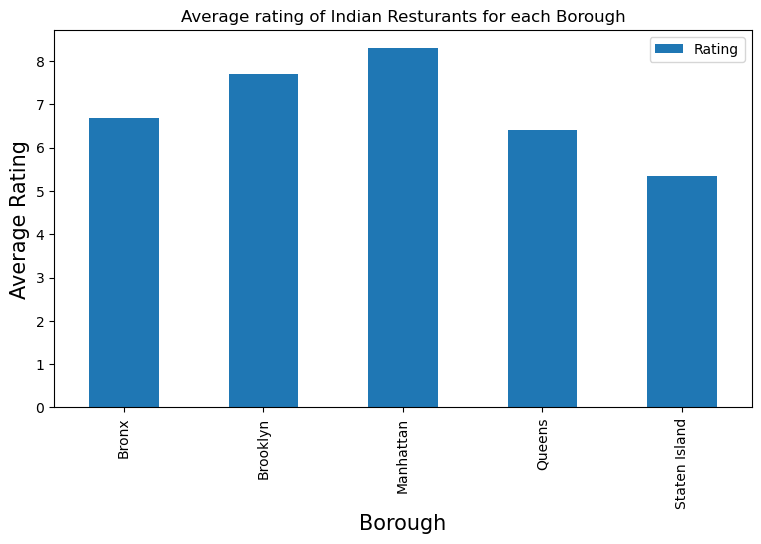

In [76]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider the neighbourhoods with average rating >= 9.0

In [78]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [79]:
ny_neighborhood_stats

,Neighborhood,Average Rating
5,Blissville,9.1
12,Civic Center,9.0
30,Greenwich Village,9.0
63,Sunnyside,9.1
67,Tribeca,9.0


In [80]:
# Merging data sets to get the lat, long
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [81]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Blissville,40.737251,-73.932442,9.1
1,Manhattan,Civic Center,40.715229,-74.005415,9.0
2,Manhattan,Greenwich Village,40.726933,-73.999914,9.0
3,Queens,Sunnyside,40.740176,-73.926916,9.1
4,Staten Island,Sunnyside,40.612760,-74.097126,9.1
5,Manhattan,Tribeca,40.721522,-74.010683,9.0


Now we will visualize this data in Map

In [82]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [83]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [84]:
# Lets add a new field to dataframe for labeling purpose
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [85]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Conclusion

* Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for indian cuisine
* Manhattan have potential Indian Resturant Market
* Staten Island ranks last in average rating of Indian Resturants
* Manhattan is the best place to stay if you prefer Indian Cuisine
